## **Imports** ##

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Import dataset
data = pd.read_csv('data/train.csv')

## **Cleaning** ##

In [3]:
# Removing high % NaN columns
data = data.loc[:, data.isnull().mean() * 100 < 25]

# Handling non-numerics
le = preprocessing.LabelEncoder()
non_numerics = data.loc[:, data.dtypes=='object'] # non-num cols
distincts = non_numerics.nunique(axis=0) # distinct vals
data = data.drop(columns = ['Name', 'Ticket']) # rm name, ticket since almost every value is unique, will lead to no corr.
non_numerics = data.loc[:, data.dtypes=='object'].columns # 'Name' and 'Embarked'
data[non_numerics] = data[non_numerics].apply(le.fit_transform) # apply label encode to the columns

## **EDA** ##

#### **Correlation Heatmap - Noise Removal** ####

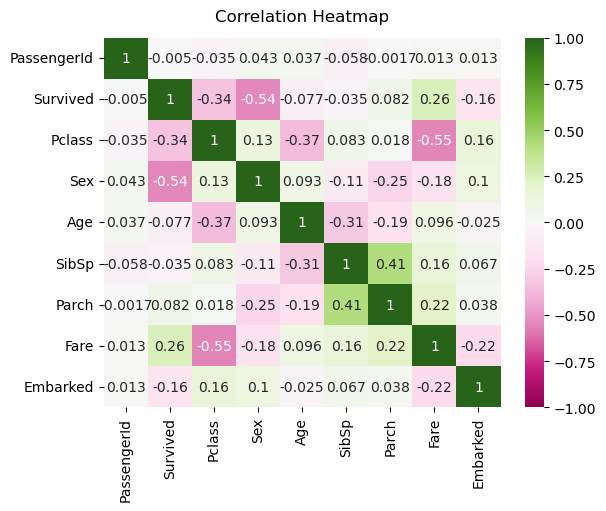

In [4]:
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap="PiYG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

#### **Results** ####
The heatmap showed the PassengerId didn't correlate with any of the other variables, including the target. This tells us that the feature is noise, so we are going to remove it.

Also, these features have the strongest correlation to Survived: Fare (.26), Sex (-.54), PClass (-.34) have the strongest correlation w/ Survived

In [5]:
# Removing PassengerId, all correlation near 0. This means the feature is likely noise
data = data.drop('PassengerId',axis=1)

#### **Target Pie Chart - Imbalance Check** ##

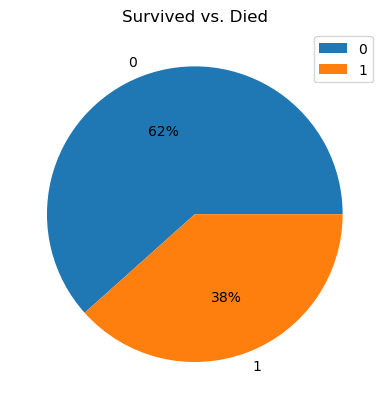

In [6]:
data.groupby('Survived').size().plot(kind='pie',autopct='%1.0f%%')
plt.title('Survived vs. Died')
plt.legend()
plt.show()

#### **Results** ####

38% survived, 62% died. No imbalance, as most people did die and theres not a huge diff. 68% people died in real life, so this dataset accurately represents the population.

#### **Histograms and Boxplots - Outliers** ####

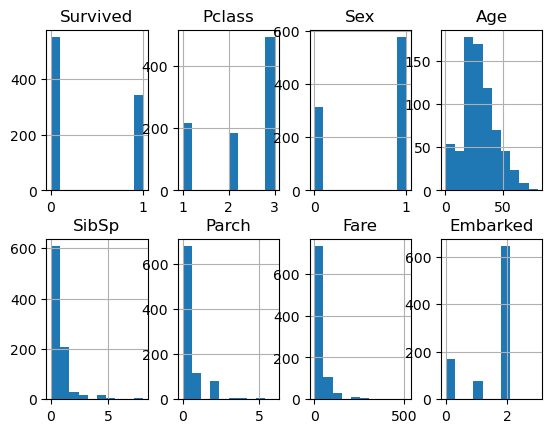

In [7]:
fig, axis = plt.subplots(2,4)
data.hist(ax=axis)
plt.show()

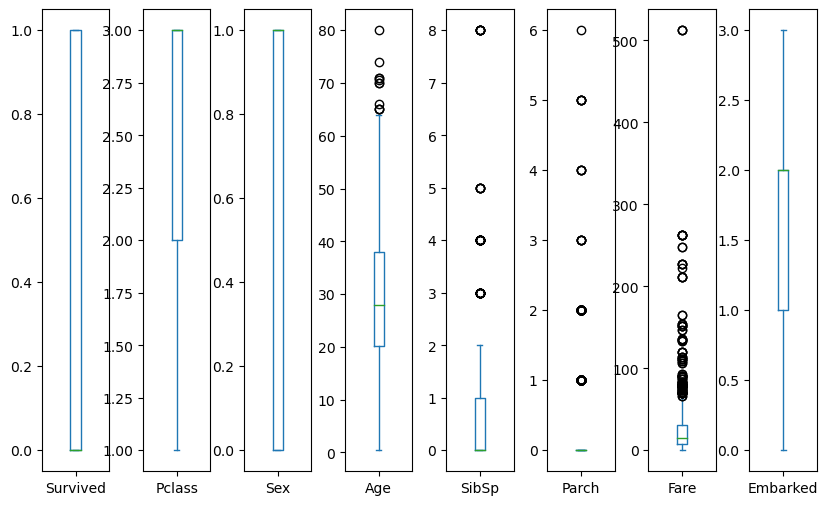

In [8]:
data.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(10, 6)
)
# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 
plt.show()

Taking a closer look at age and fare

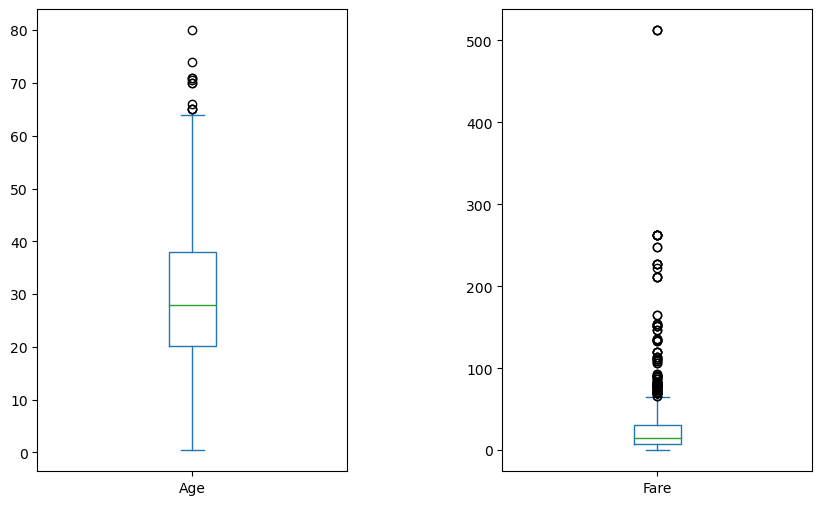

In [9]:
data[['Age','Fare']].plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(10, 6)
)
# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 
plt.show()

For this dataset, I am going to assume that its going to be difficult to fit all the features to predict survival. Hence, we will probably have to fit very tightly to the data. So, outliers will have more of an effect on the model. So its imperative that we have to exclude them, so we can generalize while at the same time fitting to the data tightly.

#### **Dropping samples such that Age and Fare have an abs(Z-Score) of > 3** ####

In [10]:
z_scores = stats.zscore(data[['Age', 'Fare']])
mask = (abs(z_scores) > 3).any(axis=1)
print(f'removing:\n\n {data[mask]}')
data = data[~mask]

removing:

      Survived  Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
27          0       1    1  19.0      3      2  263.0000         2
88          1       1    0  23.0      3      2  263.0000         2
118         0       1    1  24.0      0      1  247.5208         0
258         1       1    0  35.0      0      0  512.3292         0
299         1       1    0  50.0      0      1  247.5208         0
311         1       1    0  18.0      2      2  262.3750         0
341         1       1    0  24.0      3      2  263.0000         2
377         0       1    1  27.0      0      2  211.5000         0
380         1       1    0  42.0      0      0  227.5250         0
438         0       1    1  64.0      1      4  263.0000         2
527         0       1    1   NaN      0      0  221.7792         2
557         0       1    1   NaN      0      0  227.5250         0
679         1       1    1  36.0      0      1  512.3292         0
689         1       1    0  15.0      0      1  21

#### **Handling Nan - Imputation** ####

In [11]:
print(f'Total number of rows with NaN:\n{data.isna().sum()}\n')
# so the only NaN we have is in age, calculating percentage
print(f'Percent of Age NaN: {155/len(data)}')

Total number of rows with NaN:
Survived      0
Pclass        0
Sex           0
Age         175
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

Percent of Age NaN: 0.17795637198622274


Mean or Median Imputation?

In [12]:
print(f'Age Mean: {data[["Age"]].mean()}')
print(f'Age Median: {data[["Age"]].median()}')
# They are the same, it doesnt matter.

mean = data[['Age']].mean()
data = data.fillna(mean)

# Checking for any NaN - should return False
print(data.isnull().values.any())

Age Mean: Age    29.661164
dtype: float64
Age Median: Age    28.0
dtype: float64
False


In [14]:
# Final Shape
print(f'Final dataset shape: {data.shape}')

# Splitting X and y
X = data.loc[:, data.columns != 'Survived']
y = data[['Survived']]
print(X.shape)
print(y.shape)

Final dataset shape: (871, 8)
(871, 7)
(871, 1)


#### **Normalization** ####
For this dataset, I don't want to normalize it, due to the fact that the ranges aren't large and I want the model to be more explainable. If I run into performance issues, maybe I'll come back and normalize.